<a href="https://colab.research.google.com/github/mahesh-keswani/pytorch-example-notebook/blob/main/10_BetterWayToImplementLogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [2]:
# This returns the Bunch object, but we can treat it as python dictionary
data = load_breast_cancer()
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
X = data.data
Y = data.target.reshape(-1, 1) # Array of zero's and one's
print(X.shape, Y.shape)

(569, 30) (569, 1)


In [4]:
# The two classes which we are trying to classify
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [5]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
X_train = torch.from_numpy( X_train.astype(np.float32) )
X_test = torch.from_numpy( X_test.astype(np.float32) )
Y_train = torch.from_numpy( Y_train.astype(np.float32) )
Y_test = torch.from_numpy( Y_test.astype(np.float32) )

In [9]:
# The issue with 3_PytorchLinearClassification.ipynb is, we  calculate sigmoid and then BCELoss, but exponential can increase very fast w.r.t to its  input
# Also we are using log in binary cross entropy which almost cancels  out the exponential effect, so we  can directly substitute sigmoid instead of
# y_hat in the BCELoss. e.g  y_hat = sigmoid(wTx + b), then loss = -(ylog(y_hat) + (1 - y)log(1 - y_hat))
# instead of above, we can put sigmoid  in loss derive certain expression which adds better numerical stability.
# Also, wTx + b is called sigmoid (input to activation)

N, D = X_train.shape
model = nn.Linear(D, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam( model.parameters() )

In [10]:
EPOCHS = 1000
train_losses = []
test_losses = []

for i in range(EPOCHS):
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    train_losses.append( loss.item() )

    loss.backward()
    optimizer.step()

    test_predictions = model(X_test)
    test_loss = criterion(test_predictions, Y_test)
    test_losses.append(test_loss.item())

    if (i + 1) % 50 == 0:
        print(f"Epoch: {i + 1}/{EPOCHS}, Train_loss: {loss.item()}, Test_loss: {test_loss.item()}")

Epoch: 50/1000, Train_loss: 0.44296690821647644, Test_loss: 0.45064398646354675
Epoch: 100/1000, Train_loss: 0.33597758412361145, Test_loss: 0.3349314033985138
Epoch: 150/1000, Train_loss: 0.2764566242694855, Test_loss: 0.26805707812309265
Epoch: 200/1000, Train_loss: 0.2381911426782608, Test_loss: 0.22387979924678802
Epoch: 250/1000, Train_loss: 0.21132338047027588, Test_loss: 0.1925021857023239
Epoch: 300/1000, Train_loss: 0.19136285781860352, Test_loss: 0.16917435824871063
Epoch: 350/1000, Train_loss: 0.17594511806964874, Test_loss: 0.15123233199119568
Epoch: 400/1000, Train_loss: 0.16368213295936584, Test_loss: 0.13704939186573029
Epoch: 450/1000, Train_loss: 0.15369626879692078, Test_loss: 0.12557753920555115
Epoch: 500/1000, Train_loss: 0.1454036980867386, Test_loss: 0.11611419171094894
Epoch: 550/1000, Train_loss: 0.1384015679359436, Test_loss: 0.108173668384552
Epoch: 600/1000, Train_loss: 0.13240374624729156, Test_loss: 0.10141169279813766
Epoch: 650/1000, Train_loss: 0.127201

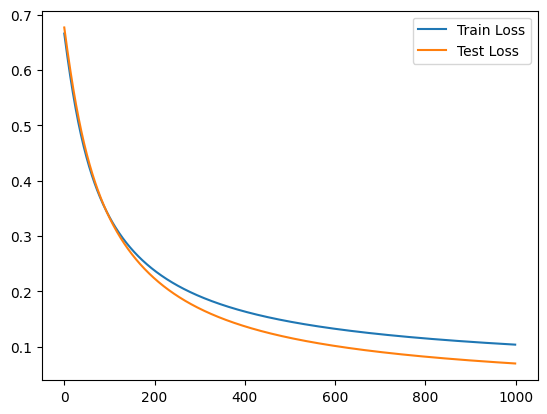

In [11]:
plt.plot(train_losses, label = "Train Loss")
plt.plot(test_losses, label = "Test Loss")
plt.legend();

In [13]:
# Now lets evaluate the accuracies
# Since we don't have sigmoid at the output, now we cannot use > 0.5 then 1 else 0
# we need  to check if logit is  > 0 inorder to decide  decision boundry
with torch.no_grad():
    # remember, the output of model is still probabilities, we need to round them up
    train_preds = (model(X_train).numpy() > 0)
    train_accuracy = np.mean( train_preds == Y_train.numpy() )

    test_preds = ( model(X_test).numpy() > 0 )
    test_accuracy = np.mean( test_preds == Y_test.numpy() )
    print(f"Train Accuracy {train_accuracy:.4f}, Test Accuracy {test_accuracy:.4f}")

Train Accuracy 0.9780, Test Accuracy 0.9912
